In [16]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function

import os.path
import sys
import time

import urllib

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Environments

In [3]:

"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.13.1


# Load Data

In [17]:
"""
references:  stanford cs231n assignment2
"""

from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 32, 32, 3)
Train labels shape:        (49000,)
Validation data shape:     (1000, 32, 32, 3)
Validation labels shape:   (1000,)
Test data shape:           (10000, 32, 32, 3)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


# Visualize Examples

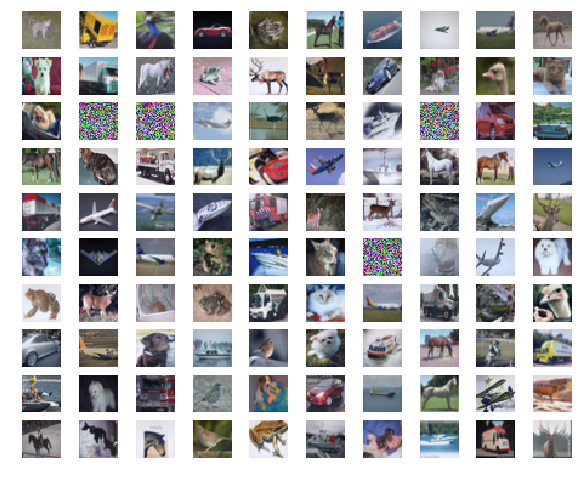

In [4]:
img = X_train[np.random.randint(0, 49000, size = 100), :]
img_max, img_min = np.max(img), np.min(img)
img = 255.0 * (img - img_min) / (img_max - img_min)
img = img.astype('uint8')

    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(img[i * 10 + j, :])
        plt.gca().axis('off')
        
plt.show()

# Reshape the image into rows

In [18]:
# Preprocessing: reshape the image data into rows
# refer to stanford cs231n assignment1
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 3072)
Train labels shape:        (49000,)
Validation data shape:     (1000, 3072)
Validation labels shape:   (1000,)
Test data shape:           (10000, 3072)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


# Model

In [19]:
def weight_variable_reg(shape, stddev, reg):
    var = tf.Variable(tf.truncated_normal(shape, stddev = stddev))
    if reg is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var), reg, name = 'weight_loss')
        tf.add_to_collection('losses', weight_loss)
    return var

from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm

def batch_norm_layer(x, train_phase, scope_bn):
    bn_train = batch_norm(x, decay=0.999, center=True, scale=True, updates_collections=None, 
                          is_training=True, reuse=None, trainable=True,scope=scope_bn)
    
    bn_inference = batch_norm(x, decay=0.999, center=True, scale=True, updates_collections=None, 
                              is_training=False, reuse=True, trainable=True, scope=scope_bn)
    
    z = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
    
    return z


def fully_connected_model(X, input_size, hidden_dims, num_classes, keep_probs,
                     use_batchnorms, train_phase, stddev=1e-2, reg=0.0):
    """
    fully_connected_model :
        (1) {affine -[batch_norm] - relu - [dropout] x (L-1) - affine}
        (2) batch_norms and dropout are controlled by use_batchnorm and keep_probs
                
    Args:
        (1) X:             an input image placeholder 
        (2) num_classes:   the number of classes to classify
        (3) input_size:    an integer giving the size of he input
        (4) hidden_dims:   a list of integers giving the size of each hidden layers
        (5) keep_prob:     a list of scalar between 0 and 1.0
        (6) use_batchnorm: a list of bools giving whether or not each network layer use
                           batch normalization
        (7) train_phase  : tf.placeholder for batch_norm
        
    Returns:
        y_out (logits)
        
    """
    dims        = [input_size] + hidden_dims + [num_classes]
    num_layers  = len(hidden_dims) + 1  
    
    a0 = X
    for i in range(num_layers-1):
        with tf.variable_scope('hidden%d' % (i+1), reuse=None) as scope:
            shape  = [dims[i], dims[i+1]]
            weight = weight_variable_reg(shape, stddev, reg)
            bias   = tf.Variable(tf.zeros([dims[i+1]]))   

            a = tf.matmul(a0, weight) + bias                

            if use_batchnorms[i]: 
                bn = batch_norm_layer(a, train_phase, 'hidden%d' % (i+1))
            else:
                bn = a

            h_relu = tf.nn.relu(bn)

            keep_prob = tf.gather_nd(keep_probs, [i])
            h_fc_drop = tf.nn.dropout(h_relu, keep_prob)

            a0 = h_fc_drop
        
    with tf.variable_scope('hidden%d' % num_layers):
        shape = [dims[-2], dims[-1]]
        weight = weight_variable_reg(shape, stddev, reg)
        bias   = tf.Variable(tf.zeros([dims[-1]]))     
        y_out = tf.matmul(h_fc_drop, weight) + bias                            
        

    return y_out


def model_loss(logits, y):
    """
    Args:
        logits: Logits tensor, float -[batch_size, NUM_CLASSES]
        y     : Labels tensor, int64 -[batch_size],   NOT ONE HOT
        
    Returns:
        loss: Loss tensor of type float    
    """
    
    y = tf.to_int64(y)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_loss = tf.reduce_mean(loss)
    
    return mean_loss  


def training(loss, update_rule, initial_learining_rate, learning_rate_decay, decay_steps):
    """
    Sets up the training Ops.
 
    Args:
        loss:          Loss tensor.
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
    """
    
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(initial_learining_rate, 
                                               global_step, decay_steps, learning_rate_decay, staircase=True)
    
    if update_rule is 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    elif update_rule is 'sgd_momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    elif update_rule is 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate)
    else:
        raise ValueError('Invalid update_rule "%s"' % update_rule)
      
    
    train_op = optimizer.minimize(loss, global_step = global_step)
    
    return train_op

def evaluation(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    correct = tf.nn.in_top_k(logits, labels, 1)

    
    return tf.reduce_mean(tf.cast(correct, tf.float32))    
        

# Graph

In [20]:
def placeholder_inputs(batch_size):
    """
    A function to generate placeholder variables for the input tensors
    
    Args:
        batch_size
        
    Returns:
        images_placeholder:  input image placeholder
        labels_placeholder:  input image labels placeholder   
        is_training       :  training or validing
    """
    
    X = tf.placeholder(tf.float32, shape=[batch_size, configs.input_size])
    y = tf.placeholder(tf.int64, shape=[batch_size])
    train_phase = tf.placeholder(tf.bool)

    return X, y, train_phase

def placeholder_keep_probs(num_hiddens):
    
    keep_probs = tf.placeholder(tf.float32, shape=[num_hiddens])
    
    return keep_probs

    
def data_next_batch(indicies, data_set, label_set, i):
    """
    Args:
        indicies:  The shuffled indexes of training data_set 
        data_set:  images from cifar10  
        label_set: labels from cifar10
        i        : the ith batch data
        
    Returns:
        images and labels for feed_dict
       
    """
    start_idx = (i * configs.batch_size) % data_set.shape[0]
    end_idx = np.min([start_idx + configs.batch_size, data_set.shape[0]])
    
    idx = indicies[start_idx : end_idx]
    
    
    return data_set[idx, :], label_set[idx]
 
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session 
    
def run_training(configs, visualization = False):
    """Train MNIST for a number of steps."""
    # Get the sets of images and labels for training, validation, and
    # test on MNIST.
    
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        X, y, train_phase = placeholder_inputs(None)
        keep_probs = placeholder_keep_probs(len(configs.hidden_dims))
        
        y_out  = fully_connected_model(X, configs.input_size, configs.hidden_dims, configs.num_classes, keep_probs, 
                                      configs.use_batchnorms, train_phase, stddev=configs.stddev, reg=configs.reg)
        
        accuracy = evaluation(y_out, y)
        
        loss = model_loss(y_out, y) + tf.get_collection('losses')
        
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):        
            train_step = training(loss, configs.update_rule, configs.initial_learining_rate, 
                             configs.learning_rate_decay, configs.decay_steps)
          
        
        saver = tf.train.Saver()

        init = tf.global_variables_initializer()
        
        sess = get_session()
        sess.run(init)
        
        iter_cnt = 1
        best_val_acc = -1
        for e in range(configs.epochs):
            validing_now = False

            train_indicies = np.arange(X_train.shape[0])
            np.random.shuffle(train_indicies)

            losses = []
            train_accuracies = []    
            for i in range(int(math.ceil(X_train.shape[0] * 1.0 / configs.batch_size))):
                batch_X, batch_y = data_next_batch(train_indicies, X_train, y_train, i)    


                if i % configs.print_every == 0:
                    feed_dict = {X: batch_X, y: batch_y, keep_probs: configs.keep_probs_test, train_phase: False}
                    train_accuracy = sess.run(accuracy, feed_dict = feed_dict)
                    print('Iter %9d, training batch accuracy %g' % (iter_cnt, train_accuracy))
                    train_accuracies.append(train_accuracy)
                    
                                        
                feed_dict = {X: batch_X, y: batch_y, keep_probs: configs.keep_probs_train, train_phase: True}
                _loss, _ = sess.run([loss, train_step], feed_dict= feed_dict)
                losses.append(_loss)
                                
                iter_cnt += 1
                
                
                
            validing_now = True 
            
            if validing_now:
                feed_val_dict = {X: X_val, y: y_val, keep_probs: configs.keep_probs_test, train_phase: False}    
                val_loss, val_acc = sess.run([loss, accuracy], feed_dict = feed_val_dict)
 
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    saver.save(sess, configs.model_path_name)
                

            print("Epoch {2}, Overall validation loss = {0}, \n validation acuracy = {1}".format(val_loss, val_acc, e+1))
            print("Epoch {1}, best validation accuracy = {0}".format(best_val_acc, e+1))
                                                      
            ## visualizing loss and accuracy 
            if visualization:
                plt.subplot(2, 1, 1)
                plt.plot(losses)
                plt.grid(True)
                plt.title('Training Loss')
                plt.xlabel('minibatch number')
                plt.ylabel('minibatch loss')

                plt.subplot(2, 1, 2)
                plt.plot(train_accuracies)
                plt.title("Training accuruacy")
                plt.xlabel("look_every number")
                plt.ylabel("correct accuracy")


                plt.show()    
        
    ## load the best model
    saver.restore(sess, configs.model_path_name)
    feed_dict = {X: X_test, y: y_test, keep_probs: configs.keep_probs_test, train_phase: False}
    test_acc = sess.run(accuracy, feed_dict = feed_dict)
        
    print("test set accuracy:   ", test_acc)
    
    return best_val_acc, test_acc




# Training

## Four Layer Fully Connected Net

Iter         1, training batch accuracy 0.0859375
Iter       151, training batch accuracy 0.289062
Iter       301, training batch accuracy 0.3125
Epoch 1, Overall validation loss = [ 2.02099586  2.02099586  2.02099586  2.02099586  2.02099586], 
 validation acuracy = 0.39200001955
Epoch 1, best validation accuracy = 0.39200001955


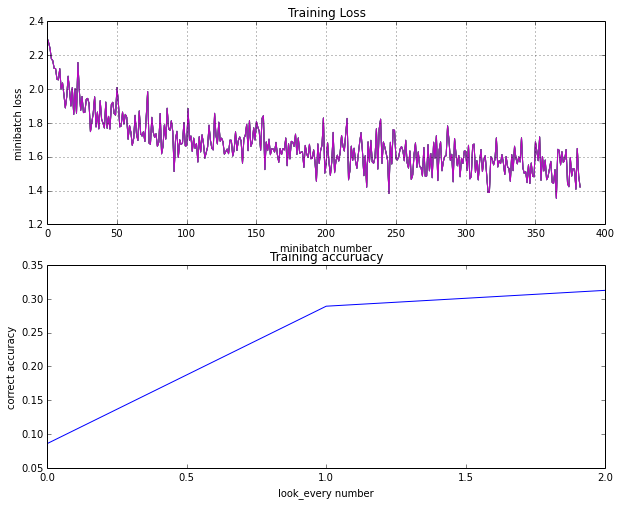

Iter       384, training batch accuracy 0.40625
Iter       534, training batch accuracy 0.335938
Iter       684, training batch accuracy 0.4375
Epoch 2, Overall validation loss = [ 1.71765375  1.71765375  1.71765375  1.71765375  1.71765375], 
 validation acuracy = 0.402000010014
Epoch 2, best validation accuracy = 0.402000010014


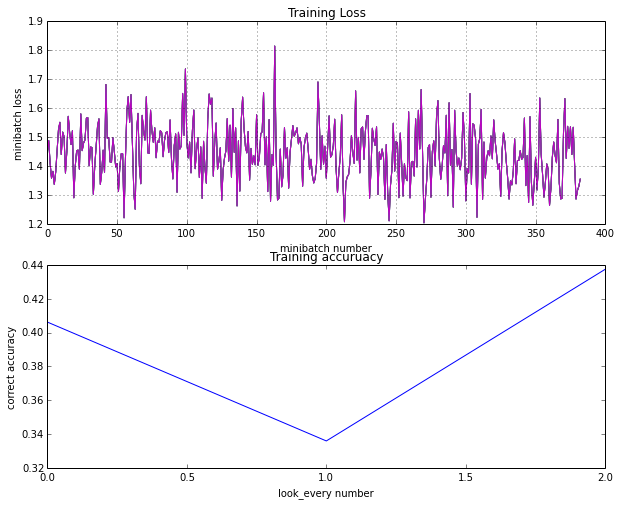

Iter       767, training batch accuracy 0.421875
Iter       917, training batch accuracy 0.414062
Iter      1067, training batch accuracy 0.460938
Epoch 3, Overall validation loss = [ 1.5420171  1.5420171  1.5420171  1.5420171  1.5420171], 
 validation acuracy = 0.442999958992
Epoch 3, best validation accuracy = 0.442999958992


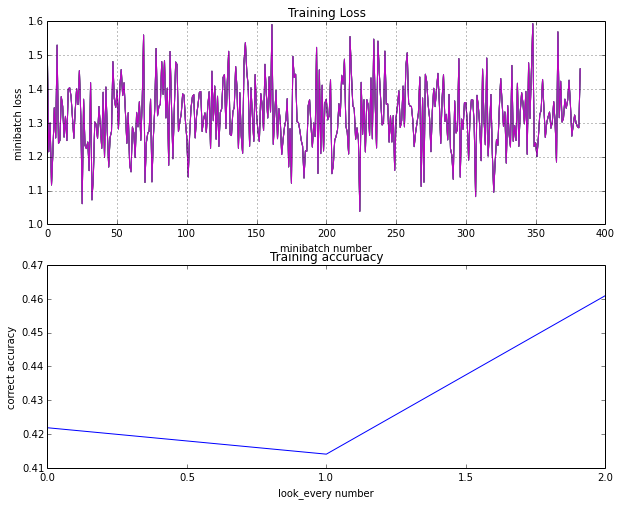

Iter      1150, training batch accuracy 0.445312
Iter      1300, training batch accuracy 0.546875
Iter      1450, training batch accuracy 0.507812
Epoch 4, Overall validation loss = [ 1.39057279  1.39057279  1.39057279  1.39057279  1.39057279], 
 validation acuracy = 0.490000009537
Epoch 4, best validation accuracy = 0.490000009537


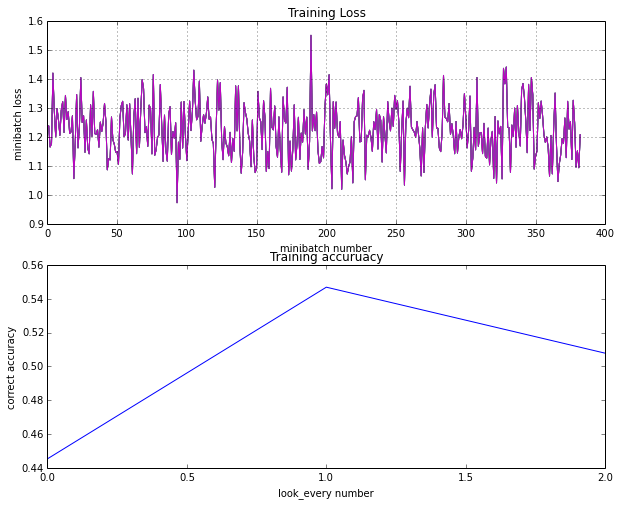

Iter      1533, training batch accuracy 0.539062
Iter      1683, training batch accuracy 0.554688
Iter      1833, training batch accuracy 0.523438
Epoch 5, Overall validation loss = [ 1.39257467  1.39257467  1.39257467  1.39257467  1.39257467], 
 validation acuracy = 0.497999995947
Epoch 5, best validation accuracy = 0.497999995947


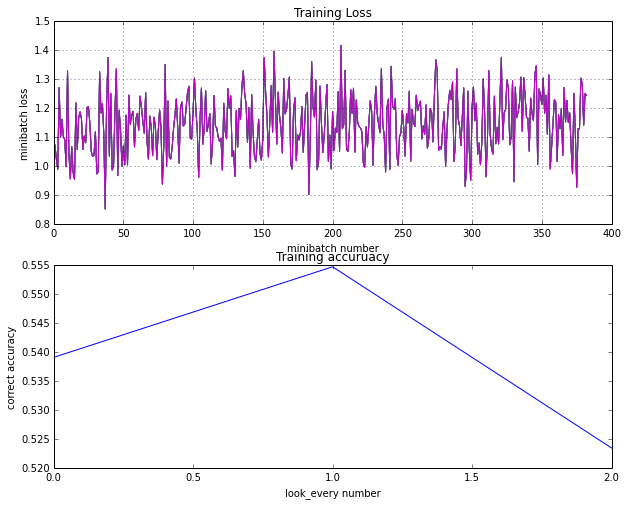

Iter      1916, training batch accuracy 0.609375
Iter      2066, training batch accuracy 0.546875
Iter      2216, training batch accuracy 0.523438
Epoch 6, Overall validation loss = [ 1.34964371  1.34964371  1.34964371  1.34964371  1.34964371], 
 validation acuracy = 0.519999980927
Epoch 6, best validation accuracy = 0.519999980927


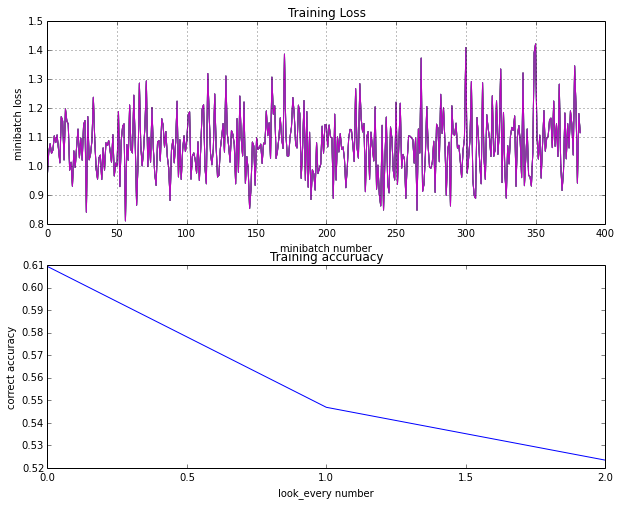

Iter      2299, training batch accuracy 0.648438
Iter      2449, training batch accuracy 0.664062
Iter      2599, training batch accuracy 0.632812
Epoch 7, Overall validation loss = [ 1.3051796  1.3051796  1.3051796  1.3051796  1.3051796], 
 validation acuracy = 0.537999987602
Epoch 7, best validation accuracy = 0.537999987602


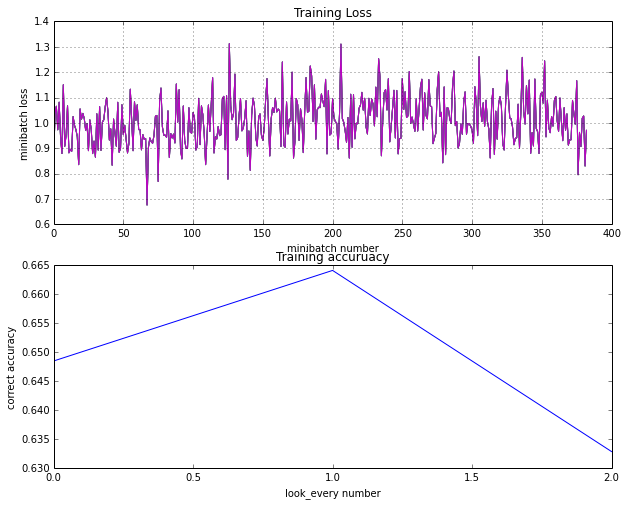

Iter      2682, training batch accuracy 0.710938
Iter      2832, training batch accuracy 0.648438
Iter      2982, training batch accuracy 0.640625
Epoch 8, Overall validation loss = [ 1.32302117  1.32302117  1.32302117  1.32302117  1.32302117], 
 validation acuracy = 0.533999979496
Epoch 8, best validation accuracy = 0.537999987602


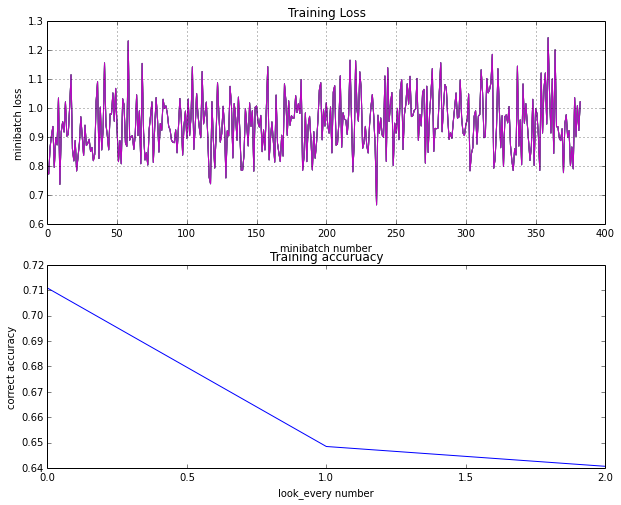

Iter      3065, training batch accuracy 0.695312
Iter      3215, training batch accuracy 0.671875
Iter      3365, training batch accuracy 0.710938
Epoch 9, Overall validation loss = [ 1.27875698  1.27875698  1.27875698  1.27875698  1.27875698], 
 validation acuracy = 0.545000076294
Epoch 9, best validation accuracy = 0.545000076294


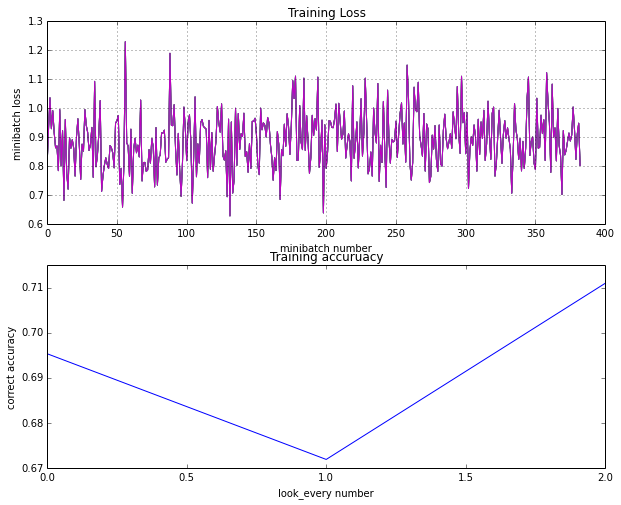

Iter      3448, training batch accuracy 0.742188
Iter      3598, training batch accuracy 0.71875
Iter      3748, training batch accuracy 0.664062
Epoch 10, Overall validation loss = [ 1.3243289  1.3243289  1.3243289  1.3243289  1.3243289], 
 validation acuracy = 0.554999947548
Epoch 10, best validation accuracy = 0.554999947548


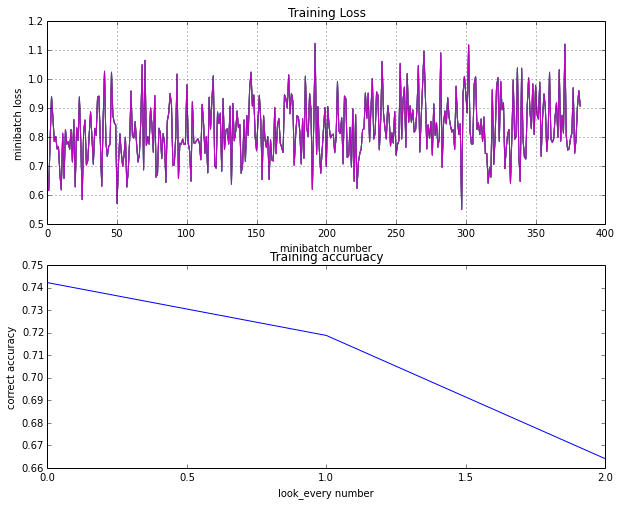

Iter      3831, training batch accuracy 0.773438
Iter      3981, training batch accuracy 0.726562
Iter      4131, training batch accuracy 0.71875
Epoch 11, Overall validation loss = [ 1.37666488  1.37666488  1.37666488  1.37666488  1.37666488], 
 validation acuracy = 0.542999982834
Epoch 11, best validation accuracy = 0.554999947548


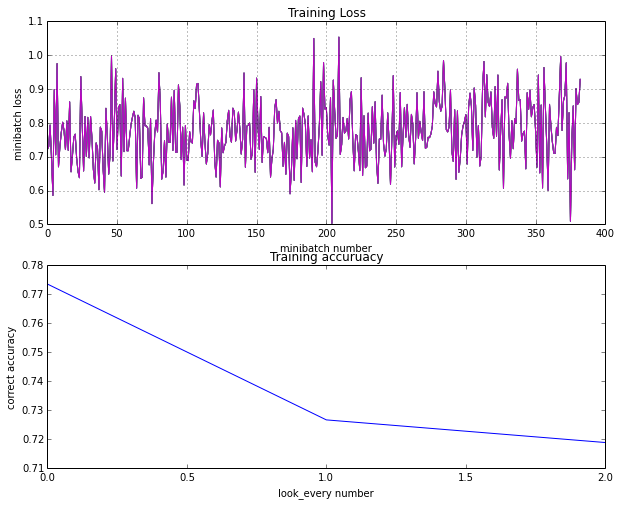

Iter      4214, training batch accuracy 0.820312
Iter      4364, training batch accuracy 0.773438
Iter      4514, training batch accuracy 0.742188
Epoch 12, Overall validation loss = [ 1.34289169  1.34289169  1.34289169  1.34289169  1.34289169], 
 validation acuracy = 0.559000015259
Epoch 12, best validation accuracy = 0.559000015259


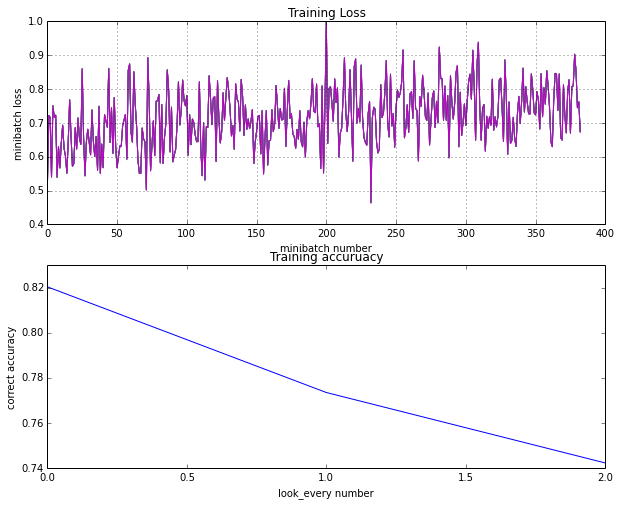

Iter      4597, training batch accuracy 0.804688
Iter      4747, training batch accuracy 0.84375
Iter      4897, training batch accuracy 0.835938
Epoch 13, Overall validation loss = [ 1.3856138  1.3856138  1.3856138  1.3856138  1.3856138], 
 validation acuracy = 0.552999973297
Epoch 13, best validation accuracy = 0.559000015259


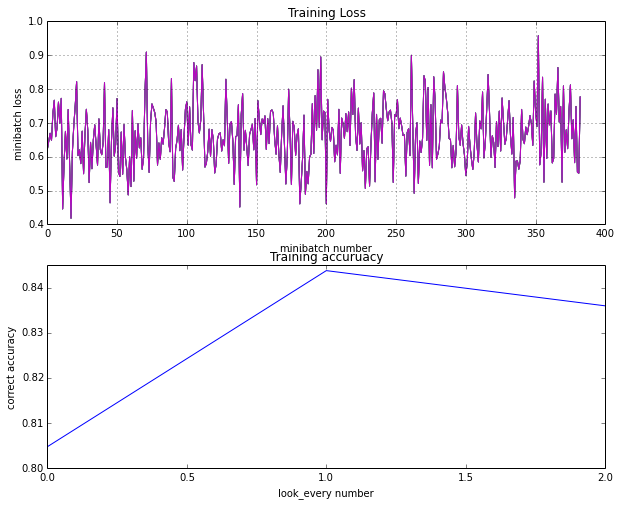

Iter      4980, training batch accuracy 0.820312
Iter      5130, training batch accuracy 0.773438
Iter      5280, training batch accuracy 0.765625
Epoch 14, Overall validation loss = [ 1.4510709  1.4510709  1.4510709  1.4510709  1.4510709], 
 validation acuracy = 0.555000007153
Epoch 14, best validation accuracy = 0.559000015259


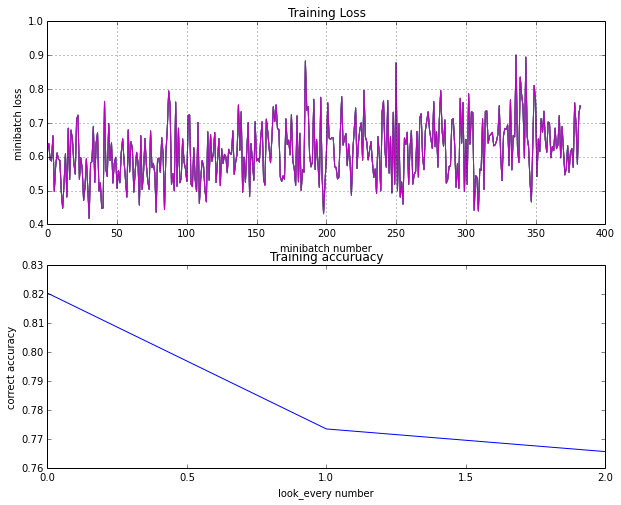

Iter      5363, training batch accuracy 0.835938
Iter      5513, training batch accuracy 0.835938
Iter      5663, training batch accuracy 0.84375
Epoch 15, Overall validation loss = [ 1.53462481  1.53462481  1.53462481  1.53462481  1.53462481], 
 validation acuracy = 0.556999921799
Epoch 15, best validation accuracy = 0.559000015259


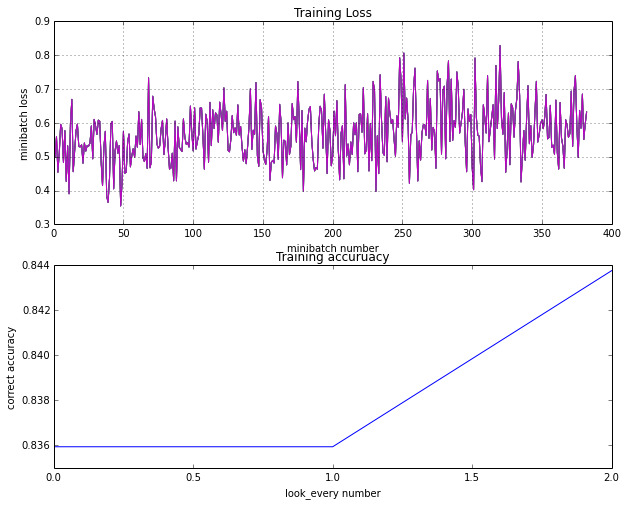

test set accuracy:    0.5573


(0.55900002, 0.55729991)

In [13]:
class configs:
    data_size = 49000
    
    input_size = 3072
    num_classes = 10
 
    hidden_dims = [200] * 4   
    keep_probs_train = [1.0] * 4 
    keep_probs_test = [1.0] * 4
    use_batchnorms = [True]* 4
    
    epochs = 15
    batch_size = 128 
    
    initial_learining_rate = 1e-3
    decay_steps = data_size // batch_size
    
    update_rule = 'adam'
    
    learning_rate_decay = 0.95
    stddev = 1.0e-2
    reg = 0.0 
    
    print_every = 150
    model_path_name = "./models/four_layer_fc_models.ckpt"
 
run_training(configs, True)

# Eight Layer Fully Connected Net

Iter         1, training batch accuracy 0.0859375
Iter       201, training batch accuracy 0.390625
Epoch 1, Overall validation loss = [ 5.20281363  1.89025557  1.88609135  1.88400173  1.8861475   1.88625383
  1.88497388  1.8835156   1.66810381], 
 validation acuracy = 0.416000008583
Epoch 1, best validation accuracy = 0.416000008583


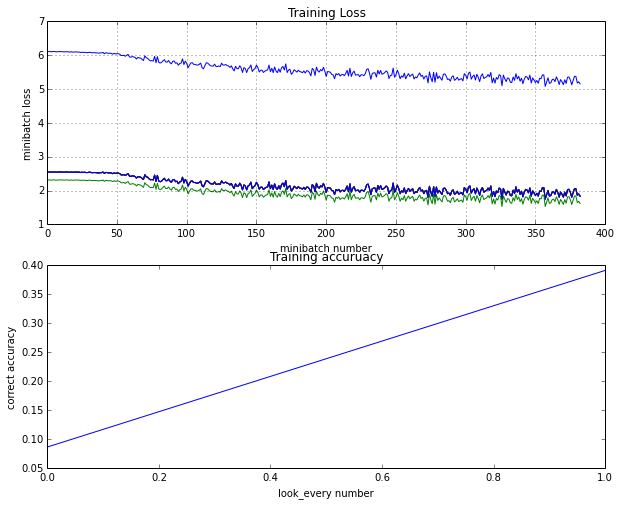

Iter       384, training batch accuracy 0.375
Iter       584, training batch accuracy 0.421875
Epoch 2, Overall validation loss = [ 4.84980345  1.75444305  1.74187636  1.73658395  1.73747337  1.73702645
  1.73568833  1.7345252   1.53626204], 
 validation acuracy = 0.471999973059
Epoch 2, best validation accuracy = 0.471999973059


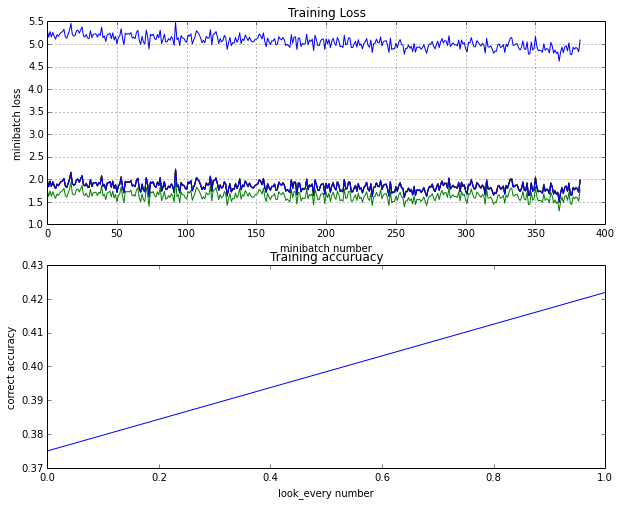

Iter       767, training batch accuracy 0.476562
Iter       967, training batch accuracy 0.515625
Epoch 3, Overall validation loss = [ 4.6134963   1.70599747  1.68186045  1.6728425   1.67238283  1.67148983
  1.67017412  1.66932344  1.48611581], 
 validation acuracy = 0.493999958038
Epoch 3, best validation accuracy = 0.493999958038


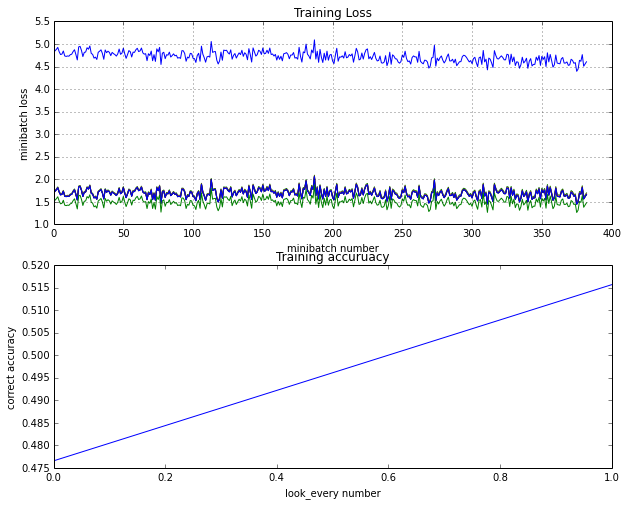

Iter      1150, training batch accuracy 0.515625
Iter      1350, training batch accuracy 0.460938
Epoch 4, Overall validation loss = [ 4.44074583  1.69725657  1.66038334  1.64721596  1.64515269  1.64387476
  1.64262331  1.64211559  1.4723351 ], 
 validation acuracy = 0.507999956608
Epoch 4, best validation accuracy = 0.507999956608


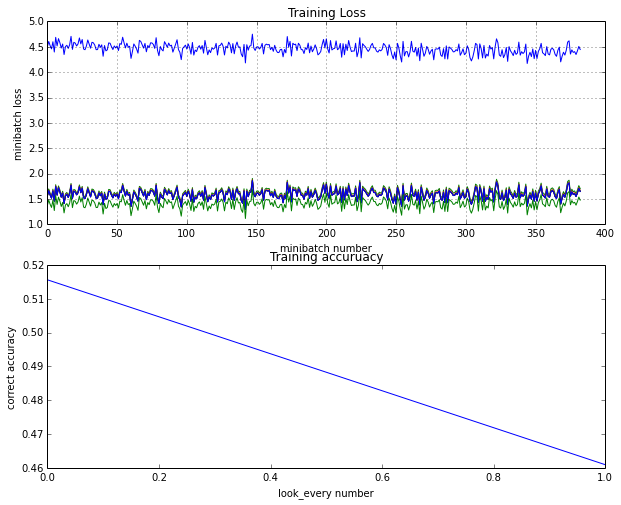

Iter      1533, training batch accuracy 0.515625
Iter      1733, training batch accuracy 0.601562
Epoch 5, Overall validation loss = [ 4.2585988   1.66022158  1.61015821  1.59252191  1.58886433  1.58722639
  1.58598197  1.58590519  1.42805624], 
 validation acuracy = 0.51700001955
Epoch 5, best validation accuracy = 0.51700001955


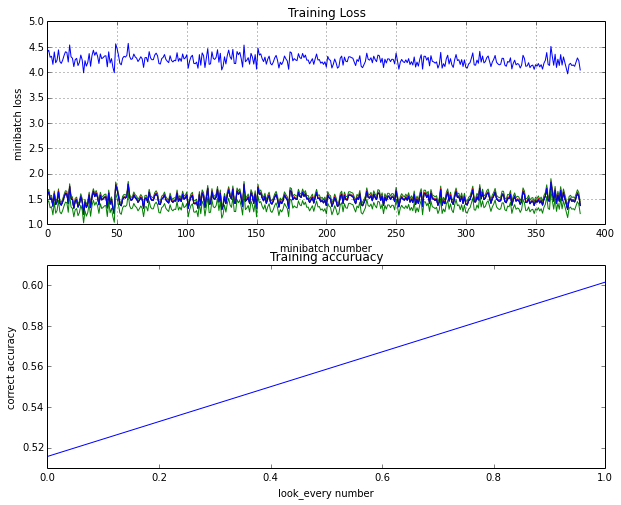

Iter      1916, training batch accuracy 0.523438
Iter      2116, training batch accuracy 0.554688
Epoch 6, Overall validation loss = [ 4.09957457  1.62880874  1.56487048  1.54228354  1.53686523  1.53483677
  1.53362286  1.53390527  1.3866353 ], 
 validation acuracy = 0.528999984264
Epoch 6, best validation accuracy = 0.528999984264


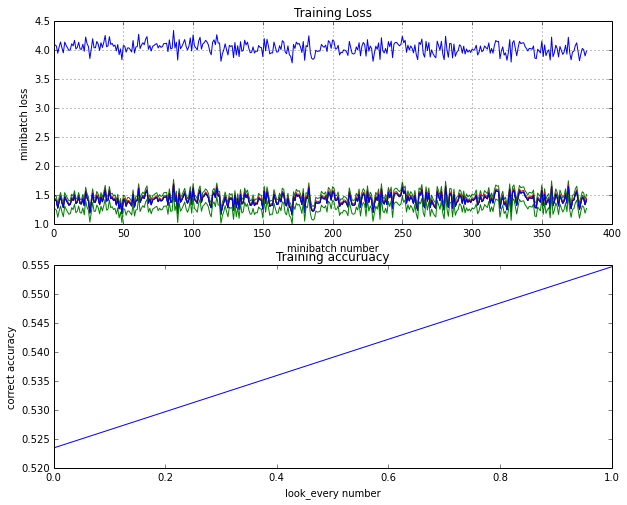

Iter      2299, training batch accuracy 0.6875
Iter      2499, training batch accuracy 0.585938
Epoch 7, Overall validation loss = [ 3.97403431  1.61626434  1.53913283  1.5112325   1.50407839  1.50163007
  1.50045896  1.50116885  1.36342621], 
 validation acuracy = 0.528999984264
Epoch 7, best validation accuracy = 0.528999984264


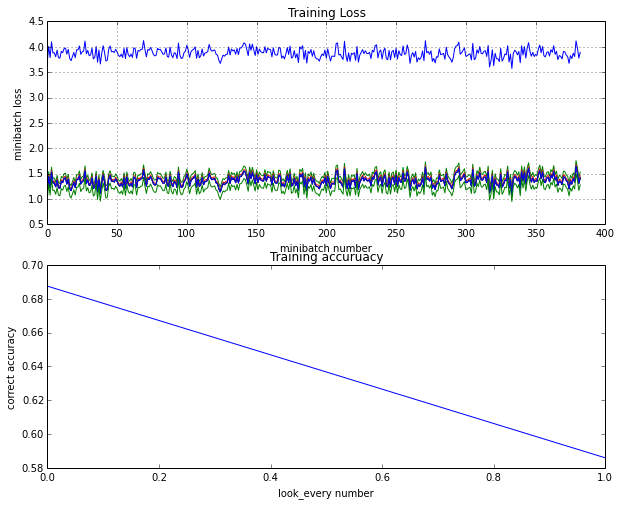

Iter      2682, training batch accuracy 0.554688
Iter      2882, training batch accuracy 0.578125
Epoch 8, Overall validation loss = [ 3.94986629  1.6938529   1.60308886  1.56930852  1.5602715   1.55737936
  1.55624402  1.55739975  1.4281944 ], 
 validation acuracy = 0.527000010014
Epoch 8, best validation accuracy = 0.528999984264


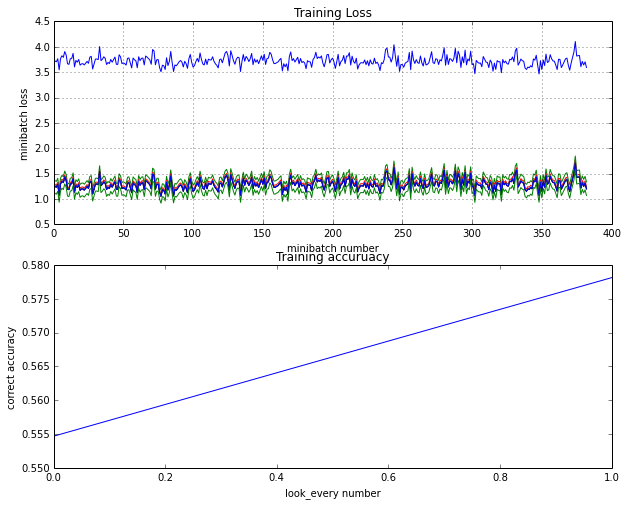

Iter      3065, training batch accuracy 0.617188
Iter      3265, training batch accuracy 0.6875
Epoch 9, Overall validation loss = [ 3.83593249  1.67023909  1.56638038  1.52663434  1.51569879  1.51239789
  1.51132095  1.51286626  1.39128387], 
 validation acuracy = 0.520999968052
Epoch 9, best validation accuracy = 0.528999984264


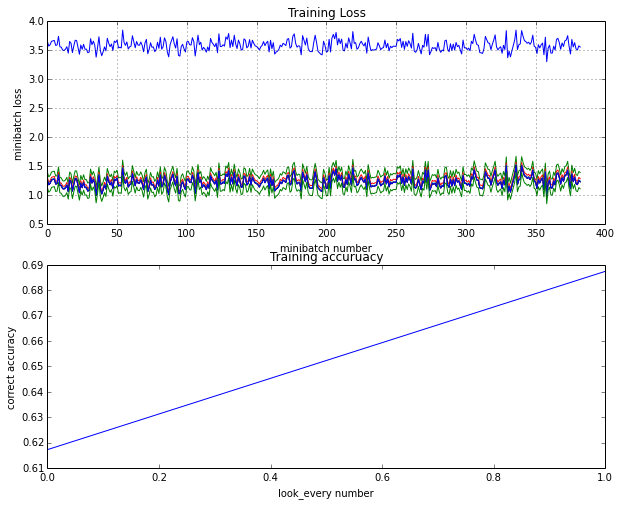

Iter      3448, training batch accuracy 0.617188
Iter      3648, training batch accuracy 0.671875
Epoch 10, Overall validation loss = [ 3.78338385  1.69920611  1.58304882  1.53717637  1.52435708  1.52067971
  1.51965392  1.5215739   1.4068979 ], 
 validation acuracy = 0.553000032902
Epoch 10, best validation accuracy = 0.553000032902


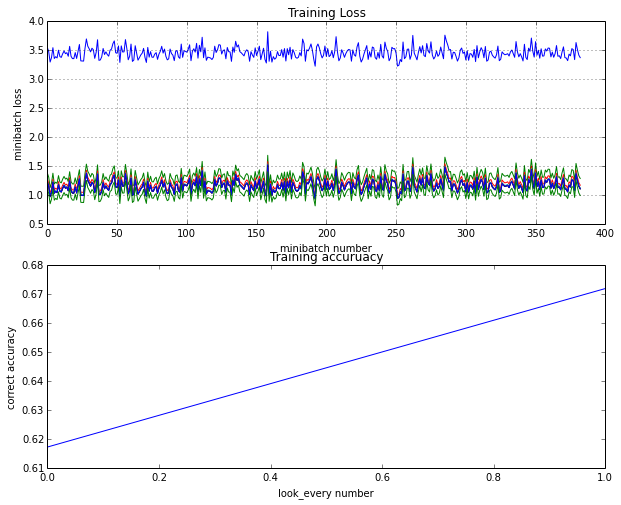

Iter      3831, training batch accuracy 0.6875
Iter      4031, training batch accuracy 0.625
Epoch 11, Overall validation loss = [ 3.7863121   1.77381468  1.64611125  1.59404695  1.5792377   1.57515681
  1.57419813  1.57648158  1.46796942], 
 validation acuracy = 0.525000035763
Epoch 11, best validation accuracy = 0.553000032902


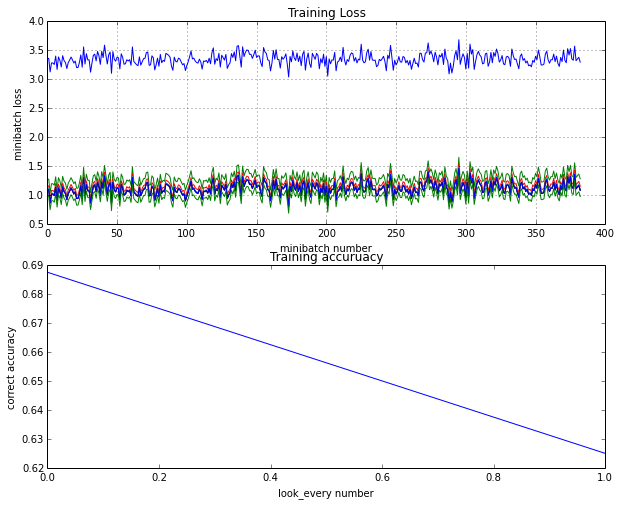

Iter      4214, training batch accuracy 0.625
Iter      4414, training batch accuracy 0.648438
Epoch 12, Overall validation loss = [ 3.7107296   1.76409316  1.62546051  1.56711495  1.55024481  1.54573894
  1.5448575   1.54749596  1.4447335 ], 
 validation acuracy = 0.54699999094
Epoch 12, best validation accuracy = 0.553000032902


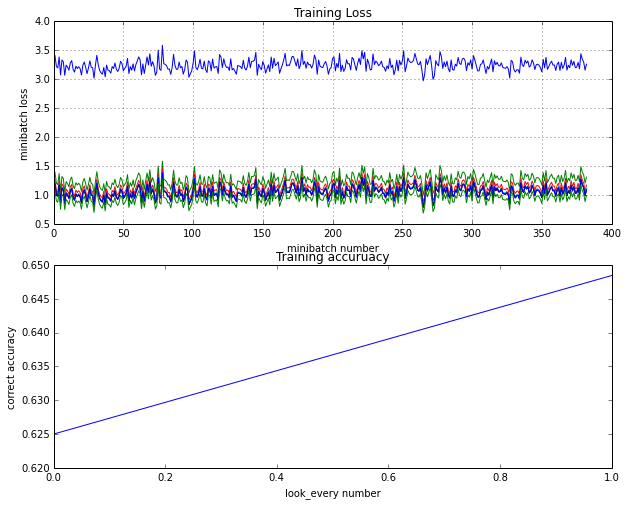

Iter      4597, training batch accuracy 0.65625
Iter      4797, training batch accuracy 0.710938
Epoch 13, Overall validation loss = [ 3.64202881  1.7546047   1.60537279  1.54041231  1.52143657  1.51650727
  1.51568973  1.51859689  1.42083776], 
 validation acuracy = 0.544000029564
Epoch 13, best validation accuracy = 0.553000032902


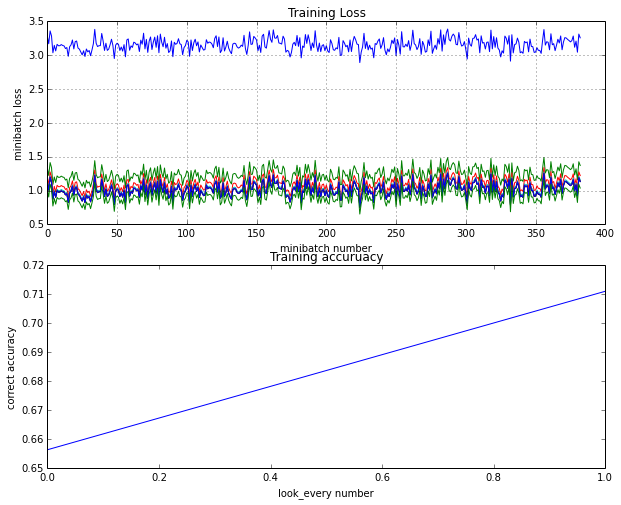

Iter      4980, training batch accuracy 0.671875
Iter      5180, training batch accuracy 0.710938
Epoch 14, Overall validation loss = [ 3.67002678  1.83710635  1.6782521   1.60696507  1.58587074  1.5805434
  1.57978678  1.58295929  1.48972833], 
 validation acuracy = 0.545000016689
Epoch 14, best validation accuracy = 0.553000032902


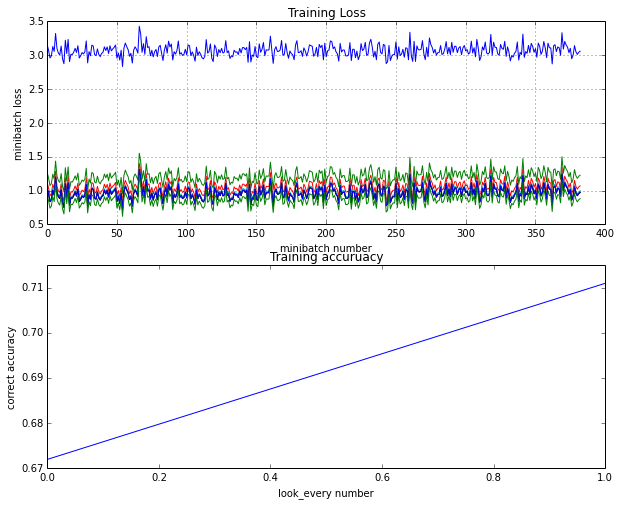

Iter      5363, training batch accuracy 0.703125
Iter      5563, training batch accuracy 0.757812
Epoch 15, Overall validation loss = [ 3.65648556  1.87203121  1.70489633  1.62744462  1.60427713  1.59854746
  1.59784567  1.60127068  1.51218212], 
 validation acuracy = 0.541999936104
Epoch 15, best validation accuracy = 0.553000032902


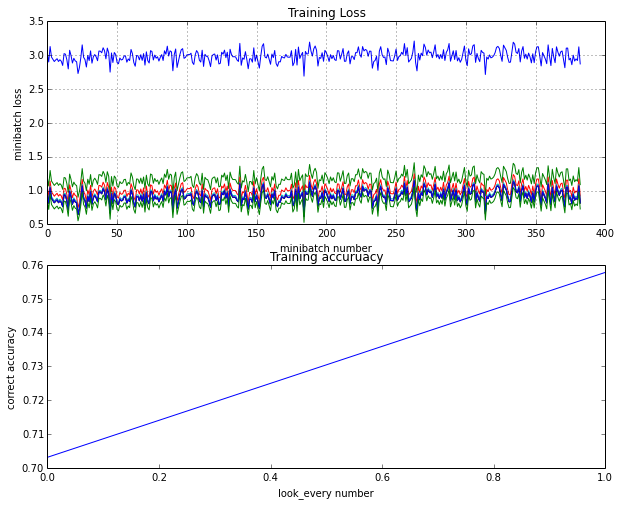

test set accuracy:    0.5296


(0.55300003, 0.52959991)

In [21]:
## no batch norm
## no dropout

class configs:
    data_size = 49000
    
    input_size = 3072
    num_classes = 10
 
    hidden_dims = [200] * 8   
    keep_probs_train = [1.0] * 8 
    keep_probs_test = [1.0] * 8
    use_batchnorms = [False]* 8
    
    epochs = 15
    batch_size = 128 
    
    initial_learining_rate = 1.0e-3
    decay_steps = data_size // batch_size
    
    update_rule = 'sgd_momentum'
    
    learning_rate_decay = 0.95
    stddev = 4.0e-2
    reg = 0.01
    
    print_every = 200
    model_path_name = "./models/eight_layer_fc_bn_models.ckpt"
 
run_training(configs, True)

Iter         1, training batch accuracy 0.078125
Iter        51, training batch accuracy 0.09375
Iter       101, training batch accuracy 0.140625
Iter       151, training batch accuracy 0.0859375
Iter       201, training batch accuracy 0.109375
Iter       251, training batch accuracy 0.0625
Iter       301, training batch accuracy 0.0703125
Iter       351, training batch accuracy 0.109375
Epoch 1, Overall validation loss = [ 5.86663389  2.55478621  2.54481864  2.54174876  2.53386736  2.53368616
  2.53133845  2.52846074  2.31220388], 
 validation acuracy = 0.111999996006
Epoch 1, best validation accuracy = 0.111999996006


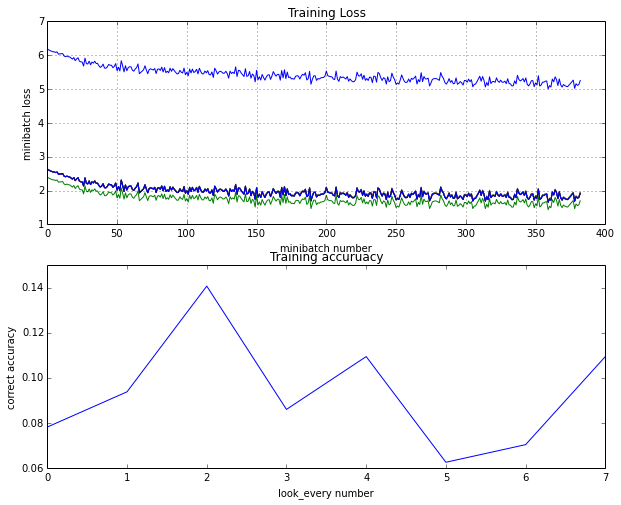

Iter       384, training batch accuracy 0.109375
Iter       434, training batch accuracy 0.125
Iter       484, training batch accuracy 0.109375
Iter       534, training batch accuracy 0.09375
Iter       584, training batch accuracy 0.0625
Iter       634, training batch accuracy 0.09375
Iter       684, training batch accuracy 0.0859375
Iter       734, training batch accuracy 0.0546875
Epoch 2, Overall validation loss = [ 5.63172531  2.5340941   2.51770353  2.51086974  2.50112581  2.49957585
  2.49618459  2.49284649  2.29144335], 
 validation acuracy = 0.112999998033
Epoch 2, best validation accuracy = 0.112999998033


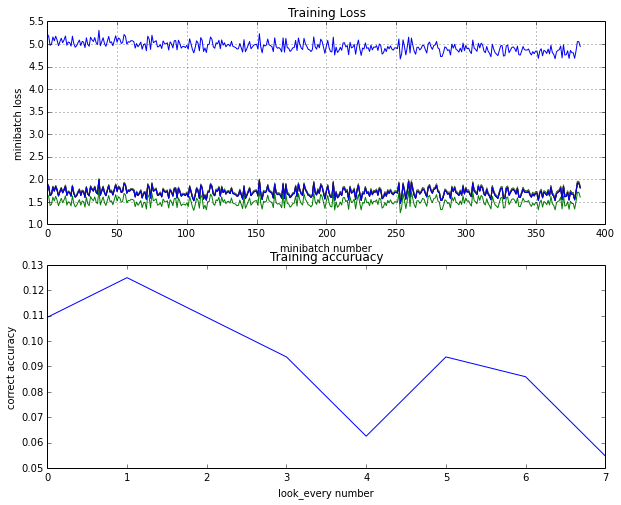

Iter       767, training batch accuracy 0.125
Iter       817, training batch accuracy 0.125
Iter       867, training batch accuracy 0.0859375
Iter       917, training batch accuracy 0.078125
Iter       967, training batch accuracy 0.0625
Iter      1017, training batch accuracy 0.101562
Iter      1067, training batch accuracy 0.148438
Iter      1117, training batch accuracy 0.195312
Epoch 3, Overall validation loss = [ 5.39174604  2.47955704  2.45653725  2.44567537  2.43388772  2.43083262
  2.42651987  2.4227283   2.23498774], 
 validation acuracy = 0.197999998927
Epoch 3, best validation accuracy = 0.197999998927


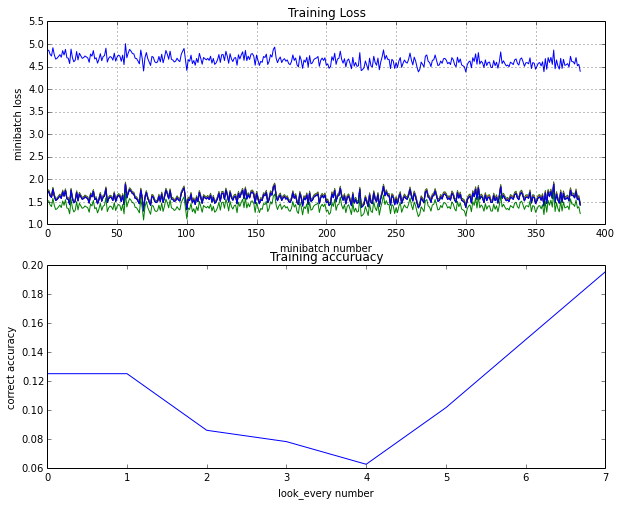

Iter      1150, training batch accuracy 0.1875
Iter      1200, training batch accuracy 0.0546875
Iter      1250, training batch accuracy 0.179688
Iter      1300, training batch accuracy 0.164062
Iter      1350, training batch accuracy 0.21875
Iter      1400, training batch accuracy 0.195312
Iter      1450, training batch accuracy 0.3125
Iter      1500, training batch accuracy 0.328125
Epoch 4, Overall validation loss = [ 5.10173798  2.35197496  2.32227135  2.30731273  2.29327869  2.28852463
  2.28321719  2.27889252  2.10375619], 
 validation acuracy = 0.323000013828
Epoch 4, best validation accuracy = 0.323000013828


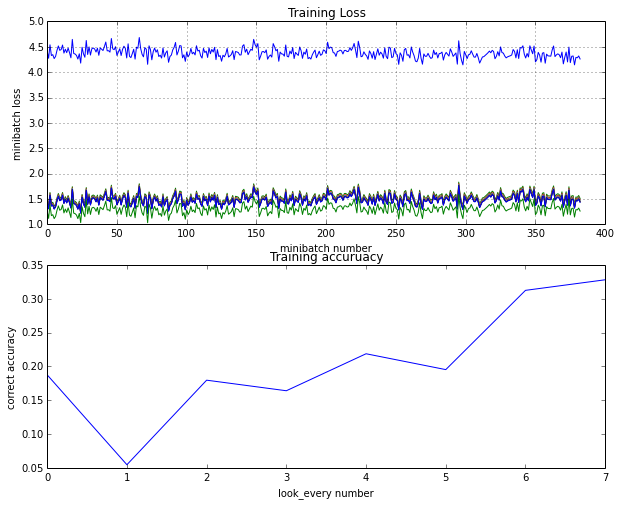

Iter      1533, training batch accuracy 0.257812
Iter      1583, training batch accuracy 0.265625
Iter      1633, training batch accuracy 0.351562
Iter      1683, training batch accuracy 0.296875
Iter      1733, training batch accuracy 0.296875
Iter      1783, training batch accuracy 0.398438
Iter      1833, training batch accuracy 0.515625
Iter      1883, training batch accuracy 0.476562
Epoch 5, Overall validation loss = [ 4.73425627  2.12664366  2.09023404  2.07118797  2.05468082  2.04809451
  2.04185057  2.03701162  1.87275684], 
 validation acuracy = 0.449000000954
Epoch 5, best validation accuracy = 0.449000000954


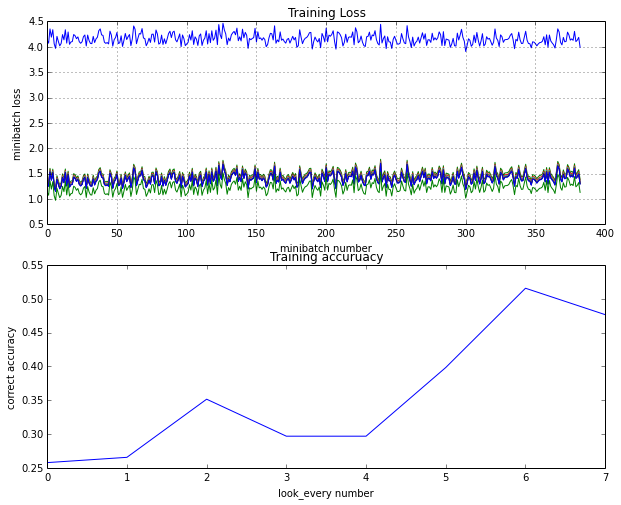

Iter      1916, training batch accuracy 0.507812
Iter      1966, training batch accuracy 0.382812
Iter      2016, training batch accuracy 0.484375
Iter      2066, training batch accuracy 0.390625
Iter      2116, training batch accuracy 0.523438
Iter      2166, training batch accuracy 0.476562
Iter      2216, training batch accuracy 0.507812
Iter      2266, training batch accuracy 0.53125
Epoch 6, Overall validation loss = [ 4.45911551  1.97681224  1.93402028  1.91103208  1.89197755  1.88347685
  1.87618303  1.87076163  1.71716821], 
 validation acuracy = 0.481999993324
Epoch 6, best validation accuracy = 0.481999993324


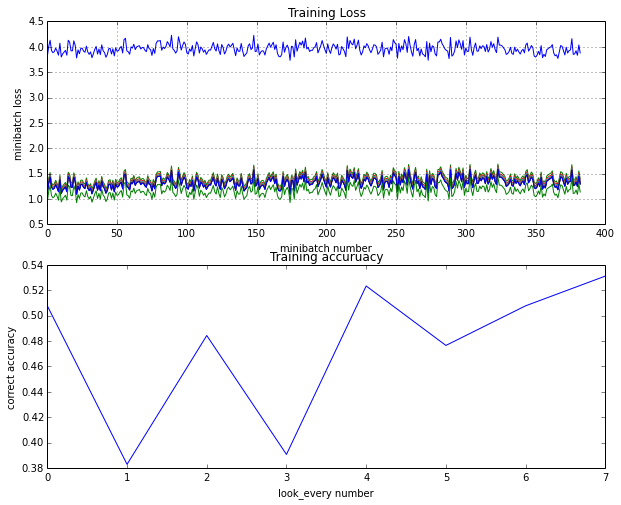

Iter      2299, training batch accuracy 0.554688
Iter      2349, training batch accuracy 0.570312
Iter      2399, training batch accuracy 0.507812
Iter      2449, training batch accuracy 0.507812
Iter      2499, training batch accuracy 0.445312
Iter      2549, training batch accuracy 0.523438
Iter      2599, training batch accuracy 0.625
Iter      2649, training batch accuracy 0.609375
Epoch 7, Overall validation loss = [ 4.17158747  1.79969692  1.75104141  1.72416091  1.70249295  1.69205308
  1.68368781  1.67762542  1.5334295 ], 
 validation acuracy = 0.502000033855
Epoch 7, best validation accuracy = 0.502000033855


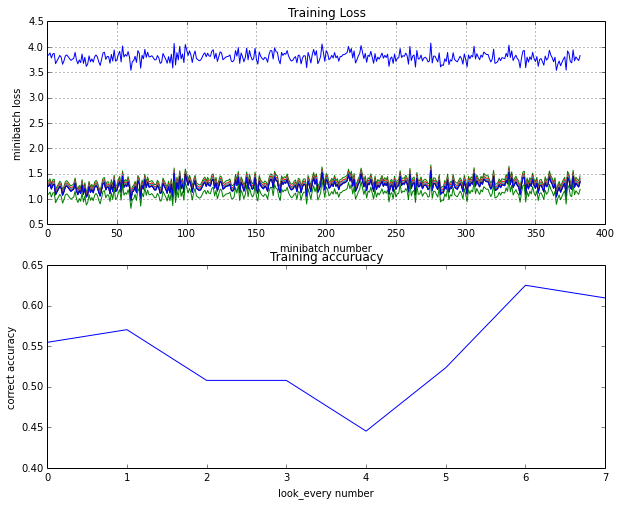

Iter      2682, training batch accuracy 0.5625
Iter      2732, training batch accuracy 0.53125
Iter      2782, training batch accuracy 0.59375
Iter      2832, training batch accuracy 0.601562
Iter      2882, training batch accuracy 0.570312
Iter      2932, training batch accuracy 0.59375
Iter      2982, training batch accuracy 0.625
Iter      3032, training batch accuracy 0.59375
Epoch 8, Overall validation loss = [ 3.97084856  1.6971252   1.64288485  1.61197579  1.58762765  1.57526124
  1.56577063  1.55908668  1.42360365], 
 validation acuracy = 0.522000014782
Epoch 8, best validation accuracy = 0.522000014782


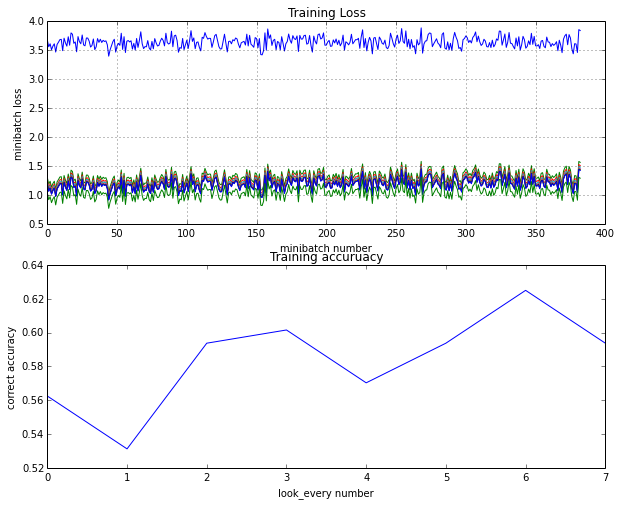

Iter      3065, training batch accuracy 0.671875
Iter      3115, training batch accuracy 0.742188
Iter      3165, training batch accuracy 0.671875
Iter      3215, training batch accuracy 0.640625
Iter      3265, training batch accuracy 0.625
Iter      3315, training batch accuracy 0.625
Iter      3365, training batch accuracy 0.625
Iter      3415, training batch accuracy 0.617188
Epoch 9, Overall validation loss = [ 3.81809282  1.63197601  1.57259822  1.53793454  1.51092589  1.49659801
  1.48595333  1.4785949   1.35081565], 
 validation acuracy = 0.541000008583
Epoch 9, best validation accuracy = 0.541000008583


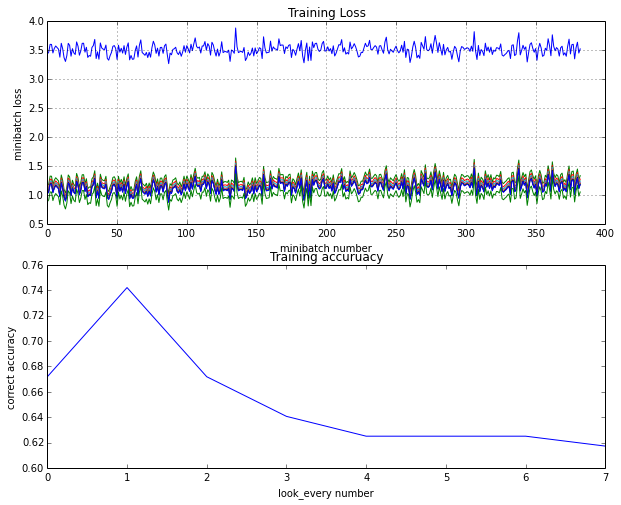

Iter      3448, training batch accuracy 0.695312
Iter      3498, training batch accuracy 0.679688
Iter      3548, training batch accuracy 0.695312
Iter      3598, training batch accuracy 0.617188
Iter      3648, training batch accuracy 0.632812
Iter      3698, training batch accuracy 0.601562
Iter      3748, training batch accuracy 0.625
Iter      3798, training batch accuracy 0.734375
Epoch 10, Overall validation loss = [ 3.76915884  1.66214967  1.5985862   1.56055939  1.5308311   1.5144974
  1.50271833  1.49468458  1.3748877 ], 
 validation acuracy = 0.524999976158
Epoch 10, best validation accuracy = 0.541000008583


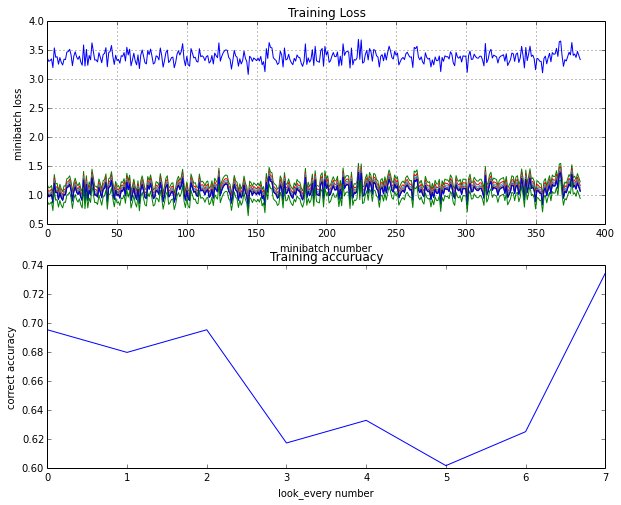

Iter      3831, training batch accuracy 0.710938
Iter      3881, training batch accuracy 0.703125
Iter      3931, training batch accuracy 0.75
Iter      3981, training batch accuracy 0.6875
Iter      4031, training batch accuracy 0.53125
Iter      4081, training batch accuracy 0.601562
Iter      4131, training batch accuracy 0.679688
Iter      4181, training batch accuracy 0.664062
Epoch 11, Overall validation loss = [ 3.7076602   1.67118406  1.6035254   1.56193686  1.52950263  1.51123762
  1.49833167  1.48958087  1.37693942], 
 validation acuracy = 0.528999984264
Epoch 11, best validation accuracy = 0.541000008583


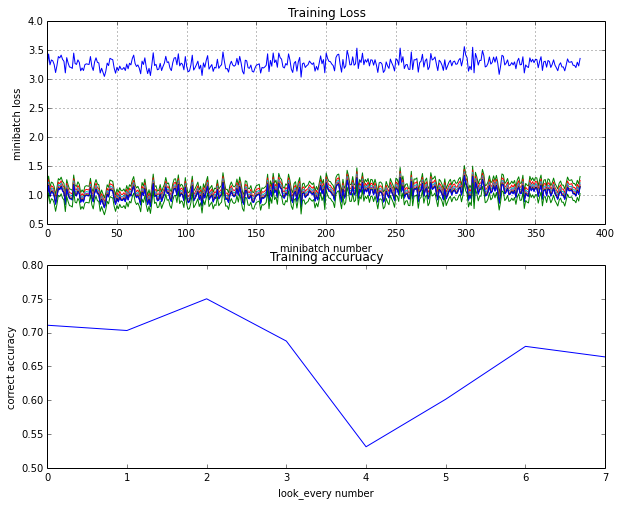

Iter      4214, training batch accuracy 0.742188
Iter      4264, training batch accuracy 0.734375
Iter      4314, training batch accuracy 0.585938
Iter      4364, training batch accuracy 0.640625
Iter      4414, training batch accuracy 0.71875
Iter      4464, training batch accuracy 0.695312
Iter      4514, training batch accuracy 0.703125
Iter      4564, training batch accuracy 0.648438
Epoch 12, Overall validation loss = [ 3.61099267  1.63791561  1.56635201  1.52137434  1.48622179  1.46610236
  1.45207953  1.44258678  1.33655405], 
 validation acuracy = 0.546000003815
Epoch 12, best validation accuracy = 0.546000003815


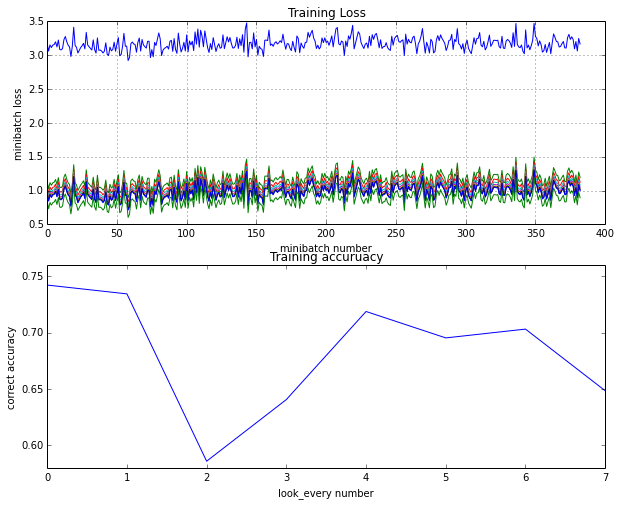

Iter      4597, training batch accuracy 0.71875
Iter      4647, training batch accuracy 0.679688
Iter      4697, training batch accuracy 0.71875
Iter      4747, training batch accuracy 0.695312
Iter      4797, training batch accuracy 0.75
Iter      4847, training batch accuracy 0.695312
Iter      4897, training batch accuracy 0.710938
Iter      4947, training batch accuracy 0.734375
Epoch 13, Overall validation loss = [ 3.65636897  1.74039292  1.66544247  1.61730826  1.57964242  1.55760527
  1.54248655  1.53223884  1.43263352], 
 validation acuracy = 0.542999982834
Epoch 13, best validation accuracy = 0.546000003815


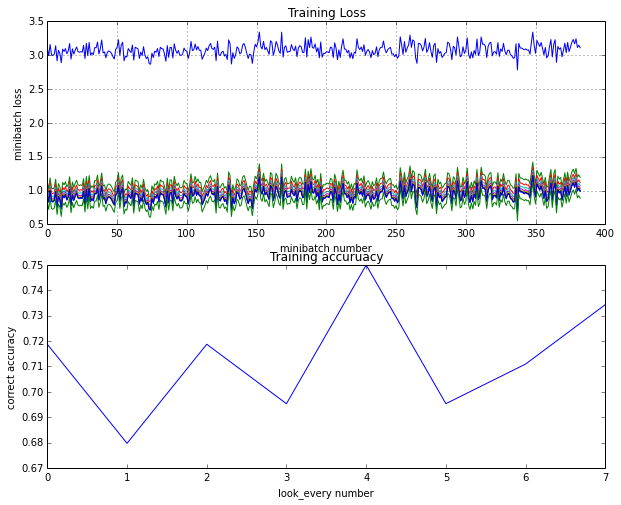

Iter      4980, training batch accuracy 0.757812
Iter      5030, training batch accuracy 0.804688
Iter      5080, training batch accuracy 0.773438
Iter      5130, training batch accuracy 0.789062
Iter      5180, training batch accuracy 0.71875
Iter      5230, training batch accuracy 0.742188
Iter      5280, training batch accuracy 0.703125
Iter      5330, training batch accuracy 0.710938
Epoch 14, Overall validation loss = [ 3.60346651  1.73951852  1.66159463  1.61071312  1.57066977  1.54679739
  1.530581    1.5196166   1.42623746], 
 validation acuracy = 0.551999986172
Epoch 14, best validation accuracy = 0.551999986172


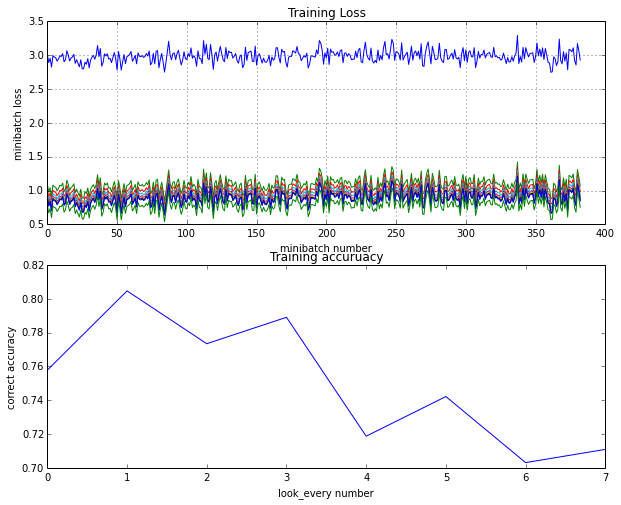

Iter      5363, training batch accuracy 0.796875
Iter      5413, training batch accuracy 0.773438
Iter      5463, training batch accuracy 0.742188
Iter      5513, training batch accuracy 0.726562
Iter      5563, training batch accuracy 0.789062
Iter      5613, training batch accuracy 0.71875
Iter      5663, training batch accuracy 0.703125
Iter      5713, training batch accuracy 0.6875
Epoch 15, Overall validation loss = [ 3.60607147  1.78888083  1.70844531  1.65490723  1.61254478  1.58677936
  1.56939971  1.55768561  1.46946204], 
 validation acuracy = 0.527999997139
Epoch 15, best validation accuracy = 0.551999986172


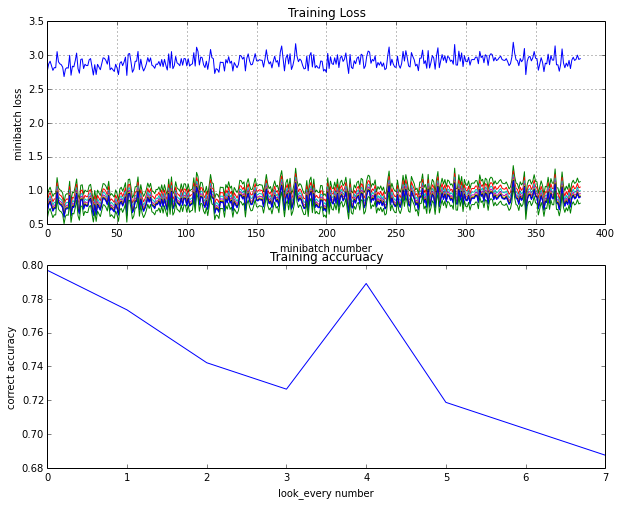

test set accuracy:    0.5207


(0.55199999, 0.52069986)

In [29]:
## with batch norm
## no dropout

class configs:
    data_size = 49000
    
    input_size = 3072
    num_classes = 10
 
    hidden_dims = [200] * 8   
    keep_probs_train = [1.0] * 8 
    keep_probs_test = [1.0] * 8
    use_batchnorms = [True]* 8
    
    epochs = 15
    batch_size = 128 
    
    initial_learining_rate = 1.0e-3
    decay_steps = data_size // batch_size
    
    update_rule = 'sgd_momentum'

    
    learning_rate_decay = 0.95
    stddev = 4.0e-2
    reg = 0.01
    
    print_every = 50
    model_path_name = "./models/eight_layer_fc_bn_models.ckpt"
 
run_training(configs, True)